In [1]:
import os
clear = lambda: os.system('clear')
clear()
import sys
import cProfile
import pstats
import numpy as np #Numpy is a 'fundamental package for scientific computing with Python'
np.set_printoptions(threshold=sys.maxsize) # This makes sure that all elements are printed, without truncation.
import scipy as sp # SciPy is a free and open-source Python library used for scientific computing and technical computing
import matplotlib.pyplot as plt # Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python.
import scipy.signal as signal

# Load the right parameters settings
#from adultPars import _init_pars # Get the parameters for resistance, elastance and uvolume
#from controlPars import _init_control # Get the control parameters loaded.
#from reflexPars import _init_reflex # Get the control parameters loaded.


#import PySimpleGUI as sg
'''
    Lex M. van Loon (lexmaxim.vanloon@anu.edu.au)
    College of Health and Medicine
    Australian National University (ANU)
    
    MIT License, Copyright (c) 2024 Lex M. van Loon
    
    Permission is hereby granted, free of charge, to any person obtaining a copy
    of this software and associated documentation files (the "Software"), to deal
    in the Software without restriction, including without limitation the rights
    to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
    copies of the Software, and to permit persons to whom the Software is
    furnished to do so, subject to the following conditions:
    The above copyright notice and this permission notice shall be included in all
    copies or substantial portions of the Software.
    
    THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
    IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
    FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
    AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
    LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
    OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
    SOFTWARE.
    
    Schematic overview of the 21-comaprtment model with:
    ---
    |x| -> the compartments, and -x- -> the flows
    ---
                       ---         ---
    ----4--------------|3|----3----|2|--------------2-----
    |                  ---         ---                   |
   ---                #0 Ascending Aorta                ---
   |4|                #1 Upper thoracic artery          |1|
   ---                #2 Upper body arteries            ---
    |                 #3 Upper body veins                |
    5                 #4 Super vena cava                 1
    |                 #5 Thoracic aorta                  |
    | ----    ----    ----    ----    ----    ----   --- |
    |-|15|-19-|16|-20-|17|-21-|18|-22-|19|-23-|20|-0-|0|-|
    | ----    ----    ----    ----    ----    ----   --- |
    |                 #6 Abdominal aorta                 |
   18                 #7 Renal arteries                  6
    |                 #8 Renal veins                     |
   ---                #9 Splanchnic arteries            ---
   |14|               #10 Splanchnic veins              |5|
   ---                #11 Lower body arteries           ---
    |                 #12 Lower body veins               |
   17                 #13 Abdominal veins                7
    |                 #14 Inferioir vena cava            |
   ---                #15 Right atrium                  ---
   |13|               #16 Right ventricle               |6|
   ---                #17 Pulmonoary arteries           ---
    |                 #18 Pulmonary veins                |
    |                 #19 Left atrium                    |
    |                 #20 left ventricle                 |
    |                   ---         ---                  |
    ----10--------------|8|----9----|7|-------------8-----
    |                   ---         ---                  |
    |                   ---         ---                  |
    ----13--------------|10|---12---|9|------------11-----
    |                   ---         ---                  |
    |                   ---         ---                  |
    ----16--------------|12|---15---|11|-----------14-----
                        ---         ---

    This file runs the model
    -----------------------------------------------------------------
    
    version 1.0 - initial
    

    -----------------------------------------------------------------
'''
secanioNo=0;
    # Load the right parameters settings
if secanioNo==0:
    print('Healthy adult sim run')
    from adultPars import _init_pars # Get the parameters for resistance, elastance and uvolume
    from controlPars import _init_control # Get the control parameters loaded.
    from reflexPars import _init_reflex # Get the control parameters loaded.
    planet=1;
    fluidLoading=0;
    StStest=0;
    bleedingOn,startTimeBleeding,totalTimeBleeding,bleedingVolume=0,150,180,2000;#  time in seconds
    fillingOn,totalTimeFilling,fillingVolume=0,200,1000;#  time in seconds

else:
    print('Healthy adult sim run')
    from adultPars import _init_pars # Get the parameters for resistance, elastance and uvolume
    from controlPars import _init_control # Get the control parameters loaded.
    from reflexPars import _init_reflex # Get the control parameters loaded.
    planet=1;
    fluidLoading=0;

# Get all the pars from the different parameters values
#global subjectPars,controlPars,reflexPars
subjectPars = _init_pars(); # Here the compartments parameters are assigned
controlPars=_init_control(); # Get all the control parameters stored to the list 'control'.You can access the heart rate for instance by contorl.hr.
reflexPars=_init_reflex(); # Get all the reflex parameters stored to the list 'reflexPars'.
# =============================================================================
# Reflex
# =============================================================================
ABRreflexOn=1; # ABR reflex
CPRreflexOn=1; # CPR reflex

# =============================================================================
# Assign the control parameters to set for how long you want to run the simulation
# =============================================================================
tmin=controlPars.tmin;
tmax=500#controlPars.tmax; # Here on can set for how long you the simulation want to run in seconds
#tmax=50;
T=0.001#controlPars.T; # Sample frequency
N=round((tmax-tmin)/T)+1;
t = np.linspace(tmin,tmax,int(tmax/T)) # create t-axis with (start point, end point, number of points)
# =============================================================================
# Interventions
# =============================================================================
startTimeStS=100/T; # IF from zero G to 1 G (standing test) and when this should start (in sec).
lbnpOn,startTimeLBNP=0,100;# 

# =============================================================================
# Initial settings; Heart rate, Intrathoracic pressure, Total blood volume and Unstressed blood volume.
# =============================================================================
HR=controlPars.hr;
HP=60/HR;
RR=controlPars.RR; 
TBV=controlPars.tbv; 
TBUV=np.sum(subjectPars.uvolume);
Pintra_t0=controlPars.Pintra_t0;
rrp=60/controlPars.RR; # Respiratory rate period
"""
Assign the parameters
"""
# Microcirculation start parameters
V_micro=controlPars.V_micro;
#CARDIAC CYCLE TIMER AND COUTER INITIALIZATIONS
nrr=1;
ncc=1;
cc=1;
nrf=1;
"""
 STATE VARIABLE INITIALIZATION
"""
# The value below are not stored every moment, only the most recent one.
V=np.zeros((21)); # number of compartments+1, this 21+1=22;
V2=np.zeros((21)); # number of compartments+1, this 21+1=22;
P=np.zeros((21));
F=np.zeros((24));
#E=np.zeros((21));
Pgrav=np.zeros((21));
E=np.array(subjectPars.elastance[0,:]);
R=np.array(subjectPars.resistance);
UV=np.array(subjectPars.uvolume[0,:]);
vl=np.array(subjectPars.vessel_length[0,:]);
abp_temp=[]; 
cvp_temp=[]; 
co_temp=[]; 
hr_temp=[];

def impulseFunction(abp_buffer,rap_buffer):
    global abp_hist,pp_hist, rap_hist,para_resp,beta_resp,alpha_resp,alpha_respv,alphav_resp,alphav_respv, s_abp, abp_ma,rap_ma,s_rap,abp_pp,pp_abp
    # Step II -> Get a moving average filter over the buffer with a width of 0.25 sec 
    abp_ma=np.append(abp_ma[1:],np.mean(abp_buffer));
    abp_pp=np.append(abp_pp[1:],np.max(abp_buffer)-np.min(abp_buffer));
    rap_ma=np.append(rap_ma[1:],np.mean(rap_buffer));
    #print(abp_ma)
    # Step III -> Great a saturation curve of the bloodpressure, this curves covers 0.25 seconds.
    s_abp = np.arctan((np.mean(abp_ma)-reflexPars.ABP_setp) / reflexPars.ABRsc)* reflexPars.ABRsc;#* control.ABRsc; 
    pp_abp = np.arctan((np.mean(abp_pp)-reflexPars.PP_setp) / reflexPars.ABRsc)* reflexPars.ABRsc;#* control.ABRsc; 
    s_rap = np.arctan((np.mean(rap_ma)-reflexPars.RAP_setp) / reflexPars.RAPsc)* reflexPars.RAPsc;
    # Step IV -> stack these curves into a new vector with the length of 60 seconds/0.0625 = 960 elements
    abp_hist = np.append(abp_hist[1:],s_abp)
    pp_hist = np.append(pp_hist[1:],np.mean(s_abp+pp_abp))
    rap_hist = np.append(rap_hist[1:],s_rap)
    # Step IV -> get the convolution of the impulse response and the blood pressure saturation curve
    para_resp=np.sum(np.flip(pp_hist,0)*reflexPars.p); 
    beta_resp=np.sum(np.flip(pp_hist,0)*reflexPars.s);
    alpha_resp=np.sum(np.flip(pp_hist,0)*reflexPars.a);
    alpha_respv=np.sum(np.flip(pp_hist,0)*reflexPars.v);
    alphav_resp=np.sum(np.flip(rap_hist,0)*reflexPars.cpa);
    alphav_respv=np.sum(np.flip(rap_hist,0)*reflexPars.cpv);


def ABRreflexDef():
    global HP,HR, ErvMAX, ElvMAX
    if HR==0:
        HP=0;
    else:
        HP=(60/HR)+beta_resp*reflexPars.RRsgain+para_resp*reflexPars.RRpgain;
        # Set some limits
        if HP < 0.31: # the heart rate can't be higher then 300
            HP=.31
        if HP > 1.5: # the heart rate cannot be lower then 40
            HP=1.5
    # Contractility feedback. Limit contractility feedback so end-systolic ventricular elastances do not become too large during severe stress.
    ErvMAX=1/(1/subjectPars.elastance[0,16]+beta_resp*0.021);
    if 1/ErvMAX < .01:
        ErvMAX=1/.01;
    ElvMAX=1/(1/subjectPars.elastance[0,20]+beta_resp*0.014);
    if 1/ElvMAX<.05:
        ElvMAX=1/.05;
    return ErvMAX, ElvMAX


def CPRreflexDef():
    # Upper body compartment
    R[0,3] = subjectPars.resistance[0,3] + -.13*alpha_resp + -.3*alphav_resp; #  vec[4]=-.13  vec[17]=-0.3
    # R kidney compartment
    R[0,8] = subjectPars.resistance[0,8] + -.13*alpha_resp + -.3*alphav_resp; #  vec[5]=-.13  vec[18]=-.3
    # R splanchnic compartment
    R[0,10] = subjectPars.resistance[0,10] + -.13*alpha_resp + -.3*alphav_resp; #  vec[6]=-.13  vec[19]=-.3
    # R lower body compartment
    R[0,12] = subjectPars.resistance[0,12] + -.13*alpha_resp + -.3*alphav_resp; #  vec[7]=-0.13  vec[20]=-.3
    
    # Venous tone feedback implementation.
    # Upper body veins compartment 
    UV[3]=subjectPars.uvolume[0,3]+alpha_respv*5.3*reflexPars.alpha+alphav_respv*13.5*reflexPars.beta #vec[8]=5.3, vec[21]=13.5
    # Renal veins
    UV[8]=subjectPars.uvolume[0,8]+alpha_respv*1.3*reflexPars.alpha+alphav_respv*2.7*reflexPars.beta; #vec[9]=1.3, vec[22]=2.7
    # Splanchnic veins
    UV[10]=subjectPars.uvolume[0,10]+alpha_respv*13.3*reflexPars.alpha+alphav_respv*64*reflexPars.beta; #vec[10]=13.3, vec[23]=64
    # Lower body veins
    UV[12]=subjectPars.uvolume[0,12]+alpha_respv*6.7*reflexPars.alpha+alphav_respv*30*reflexPars.beta; #vec[11]=6.7, vec[24]=30


""" Fluid loading"""
if fluidLoading==1:
    TBV=TBV*1.05;
# this is used to calculate the inital volume of the compartments, based on their relative unstressed volumes
for x in range(0,21): # this loops from 0 to 21
    V[x]=TBV*(UV[x]/TBUV)

"""
     RUN TIME EQUATIONS
"""
#initilize the arrays needed for the relfexes
abp_buffer=np.full(int(reflexPars.S_INT/T),reflexPars.ABP_setp) # I artifically increased the buffer time, to get at least one heart beat. Becuasew baroreceptor sense MAP not SYS.
rap_buffer=np.full(int(reflexPars.S_INT/T),reflexPars.RAP_setp);
abp_ma=np.full(4,reflexPars.ABP_setp) 
abp_pp=np.full(4,30);
rap_ma=np.full(4,reflexPars.RAP_setp) 
abp_hist=np.full(int(60/reflexPars.S_GRAN),0) 
rap_hist=np.full(int(60/reflexPars.S_GRAN),0)
pp_hist=np.full(int(60/reflexPars.S_GRAN),0)

beta_resp,para_resp,alpha_resp,alpha_respv,alphav_resp,alphav_respv=0,0,0,0,0,0;


brachioPres = np.zeros((N-1));
global output11, output12, output13, output14, output15, output16, output17, output18, output19
output1 = np.zeros((N-1));
output2 = np.zeros((N-1));       # ncc: over last cycle
output3 = np.zeros((N-1));
output4 = np.zeros((N-1));   
output5 = np.zeros((N-1));
output6 = np.zeros((N-1));
output7 = np.zeros((N-1));
output8 = np.zeros((N-1));
output9 = np.zeros((N-1));
output10 = np.zeros((N-1));

outputHR = np.zeros((N-1));

outputV = np.zeros([21,(N-1)]);
outputP = np.zeros([21,(N-1)]);
outputF = np.zeros([24,(N-1)]);
outputPg = np.zeros([21,(N-1)]);
outputE = np.zeros([22,(N-1)]);
outputMicro = np.zeros([3,(N-1)]);

abp = np.zeros((N-1));
cvp_c = np.zeros((N-1));
co_c = np.zeros((N-1));
LVP = np.zeros((N-1));
LVV = np.zeros((N-1));
RVP = np.zeros((N-1));
RVV = np.zeros((N-1));
outputPintra = np.zeros((N-1));

map=[];
cvp=[];
co=[];
hr=[];
tmeans=[];

    
"""
 Assign the Heart elastances.
"""
ElaMIN=subjectPars.elastance[1,19].copy();
ElaMAX=subjectPars.elastance[0,19].copy();
ElvMIN=subjectPars.elastance[1,20].copy();
ElvMAX=subjectPars.elastance[0,20].copy();

EraMIN=subjectPars.elastance[1,15].copy();
EraMAX=subjectPars.elastance[0,15].copy();
ErvMIN=subjectPars.elastance[1,16].copy();
ErvMAX=subjectPars.elastance[0,16].copy();
    

angle = 0; # start angle is 0, i.e. zero gravity
alpha = angle * np.pi / 180.0; # convert degrees to radians

EarthG = 9.81;
MarsG = 3.721;
rho = 1060; # Density of blood is 1060 g/ml thus 1060 kg/m^3
ConvertNtommHg = 0.0075;
if planet==2:
    Gforce = MarsG;
else:
    Gforce = EarthG;
    
# hydrostatic gravity = rho * g * h = density of the blood (g/L) * gravity (m/s^2) * height (m) = N/m2
#How to convert Newton Per Square Meter to Millimeter Of Mercury (N/m2 to mmHg)? 1 N/m2 = 0.0075006375541921 mmHg.

hydroP = Gforce*rho*np.sin(alpha)*ConvertNtommHg; 

for x in range(0,15): # zero up to and including 14
    if x in [6,11,12,13]: # the legs, IVC, and adb aorto have an even stronger gravity effect
        Pgrav[x]=(vl[x]/100)/3*hydroP;
    else:
        Pgrav[x]=(vl[x]/100)/2*hydroP;



"""
    Ventilation parameters
"""
IEratio=0.6;#% [MODEL]  6
RRP =60 /RR;
TI= RRP/(1+1/IEratio);
TE = RRP-TI;
Pmusmin=-2;#% cmH2O [MODEL]
tau = TE/5 ;#%[MODEL]


"""!!!
    Start the simulation
"""
    
for n in range(N):
    if ncc==1:
        Tav=0.12*np.sqrt(HP);
        Tsa=0.2*np.sqrt(HP);
        Tsv=0.3*np.sqrt(HP);
     
    if (ncc <= Tsa/T):
        E[19] = 0.5*(ElaMAX-ElaMIN)*(1-np.cos(np.pi*(ncc-1)*T/Tsa))+ElaMIN;
        E[15] = 0.5*(EraMAX-EraMIN)*(1-np.cos(np.pi*(ncc-1)*T/Tsa))+EraMIN;
    elif (ncc>Tsa/T and ncc<=(Tsa/T)*1.5):
        E[19] = 0.5*(ElaMAX-ElaMIN)*(1+np.cos(2*np.pi*(ncc-1)*T/Tsa))+ElaMIN;
        E[15] = 0.5*(EraMAX-EraMIN)*(1+np.cos(2*np.pi*(ncc-1)*T/Tsa))+EraMIN;
    else:
        E[19] =ElaMIN;
        E[15] =EraMIN;


#// Ventricle
    if (ncc < round((Tav)/T)):
        E[20] =ElvMIN;
        E[16] =ErvMIN;
    elif (ncc <= round((Tav+Tsv)/T)):
         E[20] = 0.5*(ElvMAX-ElvMIN)*(1-np.cos(np.pi*(ncc-round((Tav)/T))*T/(Tsv)))+ElvMIN;
         E[16] = 0.5*(ErvMAX-ErvMIN)*(1-np.cos(np.pi*(ncc-round((Tav)/T))*T/(Tsv)))+ErvMIN;
    elif (ncc>round((Tsv+Tav)/T) and ncc<=round(((Tsv+Tav)/T)*3/2)):
        temp=round(((Tsv+Tav)/T)*3/2)-round((Tsv+Tav)/T);
        E[20] =0.5*(ElvMAX-ElvMIN)*(1+np.cos(np.pi*(ncc-1-round((Tav+Tsv)/T))/temp))+ElvMIN;
        E[16]=0.5*(ErvMAX-ErvMIN)*(1+np.cos(np.pi*(ncc-1-round((Tav+Tsv)/T))/temp))+ErvMIN;
    else:
        E[20] =ElvMIN;
        E[16] =ErvMIN;


    
    """
    respiratory pattern + influence of gravity on this pressure
    """
    if nrr<=round(TI/T): # inspiration
        Pintra= Pintra_t0+((-Pmusmin/(TI*TE))*(nrr*T)**2+((Pmusmin*rrp)/(TI*TE))*(nrr*T))-(np.sin(alpha)); 
    else: # expiration
        #Pintra= Pintra_t0;
        Pintra= Pintra_t0+((Pmusmin/(1-np.exp(-TE/tau)))*(np.exp(-((nrr*T)-TI)/tau)-np.exp(-TE/tau)))-(np.sin(alpha)); 
        #print(Pintra)


# =============================================================================
#    Supine to standing test
# =============================================================================
    if StStest==1:

        tau_STS=10/T; # Please fill here to time it takes to stand up.
        
        if n > startTimeStS and n<(startTimeStS+tau_STS):
            #alpha = 90*np.sin(.5*np.pi*((n-startTimeStS/T))/(tau_STS/T))* np.pi / 180.0; # Smooth transition from standing to lying down.  Where tau_STS is a constant of the total transition time.
            tilt_time=(n-startTimeStS)
            alpha = 90*(1.0-np.cos(np.pi*tilt_time/tau_STS))/2.0;

            hydroP = Gforce*rho*np.sin(alpha*(np.pi/180))*ConvertNtommHg; 

            for x in range(0,15): # up to and including 14
                if x in [6,11,12,13]: 
                    Pgrav[x]=(vl[x]/100)/3*hydroP; # The external pressure from muscles during standing up was simulated by deviding the hydro by 3 for the leg and abdominal compartments.
                else:
                    Pgrav[x]=(vl[x]/100)/2*hydroP;
    if bleedingOn==1:
        
        if n > startTimeBleeding/T and n<(startTimeBleeding/T+totalTimeBleeding/T):
            # I want to simulate a blood loss of 1000 ml in 120 seconds from compartments 8 , 10, 12, 13
            #V[8]=V[8]-(bleedingVolume/4)/(totalTimeBleeding/T);
            #V[10]=V[10]-(bleedingVolume/4)/(totalTimeBleeding/T);
            #V[12]=V[12]-(bleedingVolume/4)/(totalTimeBleeding/T);
            #V[13]=V[13]-(bleedingVolume/4)/(totalTimeBleeding/T);
            TBV=TBV-(bleedingVolume/totalTimeBleeding*T);

    if fillingOn==1:
        if n > (startTimeBleeding+60)/T and n<(60/T+startTimeBleeding/T+totalTimeFilling/T): # 60 seconds after the bleeding started
            TBV=TBV+(fillingVolume/totalTimeFilling*T);
    """
        Calculate the pressures
    """
    # This equations calculated the new pressure based on the compartment's Elastance, volume and unstressed volume.
    # for the intra-thoracic compartments: add the intra-thoracic pressure
    P[0]=(E[0]*(V[0]-UV[0])+Pintra);
    P[1]=(E[1]*(V[1]-UV[1])+Pintra);
    P[4]=(E[4]*(V[4]-UV[4])+Pintra);
    P[5]=(E[5]*(V[5]-UV[5])+Pintra);
    P[14]=(E[14]*(V[14]-UV[14])+Pintra);
    P[15]=(E[15]*(V[15]-UV[15])+Pintra);
    P[16]=(E[16]*(V[16]-UV[16])+Pintra);
    P[17]=(E[17]*(V[17]-UV[17])+Pintra);
    P[18]=(E[18]*(V[18]-UV[18])+Pintra);
    P[19]=(E[19]*(V[19]-UV[19])+Pintra);
    P[20]=(E[20]*(V[20]-UV[20])+Pintra);

    # these 3 lines below ared to create a non-linear compliance in the venous compartment (10,12,13).
    Vmax10=1500;
    Vmax12=1000;
    Vmax13=150;
    P[10]=(np.tan((V[10]-UV[10])/(2*Vmax10/np.pi)))/((np.pi*(1/E[10]))/(2*Vmax10));
    P[12]=(np.tan((V[12]-UV[12])/(2*Vmax12/np.pi)))/((np.pi*(1/E[12]))/(2*Vmax12));
    P[13]=(np.tan((V[13]-UV[13])/(2*Vmax13/np.pi)))/(np.pi*(1/E[13])/(2*Vmax13));

    # calculate the pressures of the extrathoracic compartments
    P[2]=(E[2]*(V[2]-UV[2]));
    P[3]=(E[3]*(V[3]-UV[3]));
    P[6]=(E[6]*(V[6]-UV[6]));
    P[7]=(E[7]*(V[7]-UV[7]));
    P[8]=(E[8]*(V[8]-UV[8]));
    P[9]=(E[9]*(V[9]-UV[9]));
    P[11]=(E[11]*(V[11]-UV[11]));
 
    
    """
       Microcirculation
    """
    Pint=((V_micro/2)-(11400/2))/controlPars.C_micro;
     
    O_int = controlPars.n_int*controlPars.R_gas*controlPars.Temp/V_micro;
    O_cap = controlPars.n_cap*controlPars.R_gas*controlPars.Temp/(np.sum(V)*.6); # times .6 since only 60 percent of the blood is plasma.
     
    P_cap_lower = P[11]-(F[15]*.9*R[0,12]); # set the capillary pressure, based on the flow from art to vein and the precap resistance to be 90%
    P_cap_upper = P[2]-(F[3]*.9*R[0,3]);     # Or alternatively;    Pc = ((.1/.9)*P[11]+P[12])/(1+(.1/.9));
    
    F_micro_lower = controlPars.Kf * ((P_cap_lower-Pint)-controlPars.sigma*(O_cap-O_int))/controlPars.R_transcap;
    F_micro_upper = controlPars.Kf * ((P_cap_upper-Pint)-controlPars.sigma*(O_cap-O_int))/controlPars.R_transcap;
    
    F_lymphatic = (5+Pint-P[15])/controlPars.R_lymph; # the 5 is small constant positive pressure term that accounted for the intrinsic pumping action of the initial lymphatics (meaning that lymphatic return is possible even when interstitial tissue pressures were slightly negative).
    if F_lymphatic<0:
        F_lymphatic=0
        




   # Note; the resistance of a compartment always corresponds to the outflow resistance. !!!!
    """ 
    #
    #    Flow rates (static equations), note this flows calculate the flow into a compartment.
    #
    """
    #------------------------------------------------------#
    #---------- Left side of the heart --------------------#

    if P[20]>P[0]+Pgrav[0]:
       F[0]=(P[20]-P[0]-Pgrav[0])/R[0,0]; #q0
    else:
       F[0]=0; # no insufficiency
      

     
    #-----------Intrathoracic flow rates-------------------#
    F[1]=(P[0]-P[1]-Pgrav[1])/R[0,1];
    if F[1]<0:
        F[1]=0;
    F[2]=(P[1]-P[2]-Pgrav[2])/R[0,2];
    if F[2]<0:
        F[2]=0;
    F[3]=(P[2]-P[3])/R[0,3];# No influence of gravity for this flow.
    if F[3]<0:
        F[3]=0;
    # Starling resistor defines the flow into the superior vena cava.
    
    if ((P[3]+Pgrav[3] > P[4]) and (P[4] > Pintra)):
        F[4] = (P[3] - P[4] + Pgrav[3]) / R[0,4];
    elif ((P[3]+Pgrav[3] > Pintra) and (Pintra > P[4])):
        F[4] = (P[3] - Pintra + Pgrav[3]) / R[0,4];
    elif (Pintra > P[3]+Pgrav[3]):
        F[4] = 0.0;
        
    if P[4]-P[15]>0:
       F[5]=(P[4]-P[15]+Pgrav[4])/R[3,4]; #q5
    else:
       F[5]=(P[4]-P[15]+Pgrav[4])/(10*R[3,4]); #q5
      
    F[6]=(P[0]-P[5]+Pgrav[5])/R[0,5];
    if F[6]<0:
        F[6]=0;
    F[7]=(P[5]-P[6]+Pgrav[6])/R[0,6];
    if F[7]<0:
        F[7]=0;
    F[8]=(P[6]-P[7]+Pgrav[7])/R[0,7];
    F[9]=(P[7]-P[8])/R[0,8];# No influence of gravity for this flow.
    F[10]=(P[8]-P[13]-Pgrav[8])/R[3,8];
    F[11]=(P[6]-P[9]+Pgrav[9])/R[0,9];
    F[12]=(P[9]-P[10])/R[0,10];# No influence of gravity for this flow.
    if P[10]>P[13]+Pgrav[10]:
        F[13]=(P[10]-P[13]-Pgrav[10])/R[3,10];
    else: 
        F[13]=0;
    
    
    F[14]=(P[6]-P[11]+Pgrav[11])/R[0,11];
    F[15]=(P[11]-P[12])/R[0,12]; # No influence of gravity for this flow.
    
    if P[12]>(P[13]+Pgrav[12]):
        F[16]=(P[12]-P[13]-Pgrav[12])/R[3,12];
    else:
        F[16]=0;
    if P[13]>P[14]+Pgrav[13]:
        F[17]=(P[13]-P[14]-Pgrav[13])/R[0,14];
    else:
        F[17]=0;

    if P[14]-P[15]>0:           # Blood flow comes from both the IVC and SVC
       F[18]=(P[14]-P[15]-Pgrav[14])/R[3,14];
    else:
       F[18]=(P[14]-P[15]-Pgrav[14])/(10*R[3,14]);
      
    if P[15]-P[16]>0:
       F[19]=(P[15]-P[16])/R[0,16]; #q19
    else:
       F[19]=0;
    
    if P[16]-P[17]>0:
       F[20]=(P[16]-P[17])/R[3,16]; #20
    else:
       F[20]=0;
       
    F[21]=(P[17]-P[18])/R[0,18];# No influence of gravity for this flow.
    
    if P[18]-P[19]>0:
       F[22]=(P[18]-P[19])/R[0,19]; #q22
    else:
       F[22]=(P[18]-P[19])/(10*R[0,19]); # this allows for some insufficiency 
   
   #print(Pla, Plv, Pasa, Rla)
    
    if P[19]-P[20]>0:
       F[23]=(P[19]-P[20])/R[0,20]; #q23
    else:
       F[23]=0; # no insufficiency
    #------------------------------------------------------# 
    # Update the new volumes based on the flows (dynamic equations)
    #------------------------------------------------------# 
    #-----------Cardiac (updated) volumes------------------#
    V[19]=V[19]+T*(F[22]-F[23]);
    V[20]=V[20]+T*(F[23]-F[0]);
    V[15]=V[15]+T*(F[5]+F[18]-F[19]);# Lymphatic voluem is return to the rigth atrium
    V[16]=V[16]+T*(F[19]-F[20]);
    #-----------Intrathoracic (updated) volumes------------#
    V[17]=V[17]+T*(F[20]-F[21]);         # Flow in = same compartment flow, and Flow out is next compartment flow
    V[18]=V[18]+T*(F[21]-F[22]);
    V[1]=V[1]+T*(F[1]-F[2]);
    V[4]=V[4]+T*(F_lymphatic+F[4]-F[5]);
    V[14]=V[14]+T*(F[17]-F[18]);
    V[5]=V[5]+T*(F[6]-F[7]);
     
    V[0]=V[0]+T*(F[0]-F[1]-F[6]);
    #-----------Extrathoracic (updated) volumes------------#
    V[6]=V[6]+T*(F[7]-F[8]-F[11]-F[14]);  
    V[13]=V[13]+T*(F[10]+F[13]+F[16]-F[17]); # qab_loss, is blood flow loss due to gravity/postion of the body.
    V[11]=V[11]+T*(F[14]-F[15]);
    # Lower body venous compartment, get the microcirculation added
    V[12]=V[12]+T*(F[15]-F[16]-F_micro_lower); # qll_loss, is blood flow loss due to gravity/postion of the body.
    V[7]=V[7]+T*(F[8]-F[9]);  
    V[8]=V[8]+T*(F[9]-F[10]);  
    V[9]=V[9]+T*(F[11]-F[12]);  
    V[10]=V[10]+T*(F[12]-F[13]);  # qsp_loss, is blood flow loss due to gravity/postion of the body.
    V[2]=V[2]+T*(F[2]-F[3]);  
    # Upper body venous compartment, gets the microcirculation added
    V[3]=V[3]+T*(F[3]-F[4]-F_micro_upper);
    V_micro = V_micro+T*(F_micro_lower+F_micro_upper-F_lymphatic);

    # Step I -> Get a constant array of the aortic arch and rap pressure of the most recent 4*S_GRAN seconds
    abp_buffer=np.append(abp_buffer[1:],P[0]); #Note, the baroreflex does not incorparate the baroreceptors in the carotid arteries 
    rap_buffer=np.append(rap_buffer[1:],P[15]); 
    nrf=nrf+1;
    #print(HP)
    """
     The baroreflex and CPReflex
    """
    #print(para_resp,beta_resp,alpha_resp,alpha_respv,alphav_resp,alphav_respv)
    if nrf==1+round(reflexPars.S_GRAN/T) and (ABRreflexOn==1 or CPRreflexOn==1): # Call every (0.0625/0.001) 62 run the umpulsefunction
        nrf=1; #reset the timer for the reflexes
       # create impulse response
        impulseFunction(abp_buffer,rap_buffer);
        #print('ja aanz')
   
    if ABRreflexOn==1:
        #print('ja aan')
        ErvMAX, ElvMAX=ABRreflexDef();
           
    if CPRreflexOn==1:
        CPRreflexDef();
           
    ncc=ncc+1;
    nrr=nrr+1;
   #print(ncc,round(HP/T))
   #!!!
    abp_temp.append(P[0]); # Geber use compartment [0] to plot aortic pressure
    cvp_temp.append(P[15]);
    co_temp.append(F[0]);
    hr_temp.append(HP);
    if nrr>1+round(RRP/T):   # if end of cycle
       nrr=1;                # start new one
   
    if ncc>1+round(HP/T):   # if end of cycle
       ncc=1;                # start new one
      #print(60/HP,'hoi')
      #sbp(cc)=max(abp);     # over last cycle
       tmeans.append(n*T);
       #map.append(np.mean(abp_temp));
       map.append(np.max(abp_temp)*1/3+2/3*np.min(abp_temp));
       cvp.append(np.mean(cvp_temp));
       co.append(np.trapz(co_temp)*(60/HP)*1/(1000/T)); # 1000000 = ml ot liter and T
       #print(np.trapz(co_temp),60/HP)
       if HP==0:
           hr.append(0)
       else:
           hr.append(np.mean(60/HP))
       abp_temp=[]; 
       cvp_temp=[]; 
       co_temp=[]; 
       hr_temp=[];
      # state variables should be saved here.
       cc=cc+1;
    """
       Make sure there is no volume added or removed as a result of the integration
    """
    if n>5/T: # after 1 second; check the volumes
        V[13]=V[13]+TBV-np.sum(V)+controlPars.V_micro-V_micro;
   
   # selected outputs #
    brachioPres[n-1]=P[1];
    abp[n-1]=P[0];    # n: over whole time range
    cvp_c[n-1]=P[15];    # n: over whole time range
    co_c[n-1]=F[0]*60*T/1000;    # n: over whole time range
    LVP[n-1]=P[20];
    LVV[n-1]=V[20];
    RVP[n-1]=P[16];
    RVV[n-1]=V[16];
    

    output8[n-1]=hydroP;
    output9[n-1]=alpha;     # n: over whole time range
    
    outputPintra[n-1]=Pintra;
    outputV[:,n-1]=V;
    outputP[:,n-1]=P;
    outputF[:,n-1]=F;
    outputE[:,n-1]=E;
    outputPg[:,n-1]=Pgrav;
    outputMicro[0,n-1]=F_micro_lower;
    outputMicro[1,n-1]=F_micro_upper;
    outputMicro[2,n-1]=F_lymphatic;
    outputHR[n-1]=60/HP;        # ncc: over last cycle


Healthy adult sim run


/var/folders/q8/kgrh44n54fg5dqkc6j0qnyk00000gn/T/ipykernel_5518/569622761.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  startpointplot=np.int(100/T)


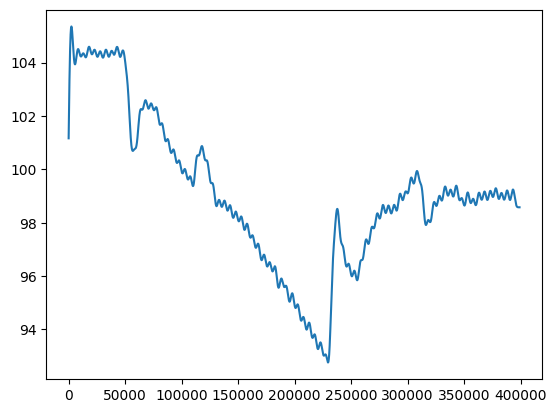

In [2]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# can you give a function for a lowpass butterworth filter with a cutoff frequency of 0.5 Hz
# and a sampling frequency of 1000 Hz
# the order of the filter is 6
# the cutoff frequency is 0.5 Hz
# the sampling frequency is 1000 Hz

def butter_lowpass_filter(data, cutoff=0.5, fs=1000, order=6):
    """
    Apply a lowpass Butterworth filter to the given data.
    
    Parameters:
    - data: The input signal.
    - cutoff: The cutoff frequency of the filter in Hz.
    - fs: The sampling frequency of the data in Hz.
    - order: The order of the filter.
    
    Returns:
    - y: The filtered signal.
    """
    # Normalize the frequency
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    
    # Get the filter coefficients
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    
    # Apply the filter
    y = signal.filtfilt(b, a, data)
    return y


wnd_size1=25000;
startpointplot=np.int(100/T)
map_av=moving_average(outputP[0,startpointplot:], wnd_size1);
map_a2=butter_lowpass_filter(outputP[0,startpointplot:], 0.5,1/T, 6);

# Example usage
# Create a sample signal
fs = 1000  # Sampling frequency in Hz
t = np.arange(0, 1, 1/fs)  # Time vector
freq = 1000  # Frequency of the signal in Hz
data = outputP[0,startpointplot:]  # Signal 
# Apply the filter
filtered_data = butter_lowpass_filter(data, .15, fs, 4)

plt.plot(filtered_data[1000:])

# get the size of filtered_datas


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ValueError: x and y must have same first dimension, but have shapes (1000,) and (1450,)

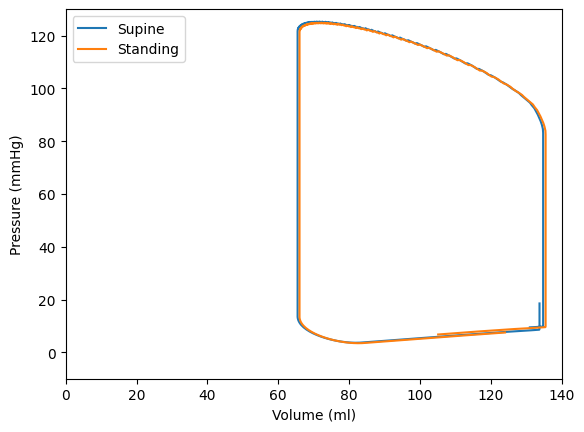

In [4]:
"""
% GRAPHICAL OUTPUT
"""

"""
Create PV-loops
"""
startPVloop1=int(40/T);

endPVloop1=int(startPVloop1+((60/outputHR[int(40/T)]+.1)/T));
startPVloop2=int(120/T);
endPVloop2=int(startPVloop2+((60/outputHR[int(40/T)]+.1)/T));

plt.figure()
plt.plot(LVV[startPVloop1:endPVloop1],LVP[startPVloop1:endPVloop1])
plt.plot(LVV[startPVloop2:endPVloop2],LVP[startPVloop2:endPVloop2])
plt.xlim((0,140))
plt.ylim((-10,130))
plt.legend(('Supine','Standing'))
plt.xlabel('Volume (ml)')
plt.ylabel('Pressure (mmHg)')

plt.savefig('PV.eps', format='eps')


" Cardiac elastances"

plt.plot(t[0:1450],outputE[15,0:1450],'--b') # rigth atrial elastance
plt.plot(t[0:1450],outputE[16,0:1450],'b') # rigth ventricular elastance
plt.plot(t[0:1450],outputE[19,0:1450],'--r') # left atrial elastance
plt.plot(t[0:1450],outputE[20,0:1450],'r') # left ventricular elastance
    #plt.title('Heart elastances')
plt.xlabel('Time (seconds)')
plt.ylabel('Elastance (mmHg/ml)')
plt.legend(('Right atrium','Right ventricle','Left atrium','Left ventricle'))
plt.savefig('cardiac elastances.eps', format='eps')
# ''' Create gravity plot'''
# plt.figure()
# plt.plot(t,output8/0.738)
# plt.xlabel('Time (seconds)')
# plt.ylabel('Gravity (Gz)')

# plt.figure()
# plt.plot(RVV[startPVloop1:endPVloop1],RVP[startPVloop1:endPVloop1])
# plt.plot(RVV[startPVloop2:endPVloop2],RVP[startPVloop2:endPVloop2])
# plt.legend(('0Gz','1Gz'))
# plt.xlabel('Volume (ml)')
# plt.ylabel('Pressure (mmHg)')

"""

Create central hemodynamic plots

"""
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

wnd_size1=25;
wnd_size2=30;
hr_av=moving_average(hr, wnd_size2);
co_av=moving_average(co, wnd_size1);
cvp_av=moving_average(co, wnd_size1);
map_av=moving_average(map, wnd_size1);


def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["right"].set_position(("axes", 1.2))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par2)
# Second, show the right spine.
par2.spines["right"].set_visible(True)


startpointplot=50;
#p1, = host.plot(t,abp,'tomato', linewidth=.5, label="ABP")
p1, = host.plot(tmeans[startpointplot:],map_av[startpointplot:],'red', linewidth=2, label="MABP")

#p1, = host.plot(t,cvp_c,'turquoise', linewidth=.5, label="CVP")
p1, = host.plot(tmeans[startpointplot:],cvp[startpointplot:],'blue', linewidth=2, label="MCVP")

tmeans2= [x+(wnd_size1/2) for x in tmeans]
tmeans3= [x+(wnd_size2/2) for x in tmeans]
p2, = par2.plot(tmeans3[startpointplot-wnd_size2+10:hr_av.size],hr_av[startpointplot-wnd_size2+10:],'lime', linewidth=1, label="Heart rate")
#p2, = par2.plot(t,output10,'lime', linewidth=1, label="Heart rate")
p3, = par1.plot(tmeans2[startpointplot-wnd_size1+5:co_av.size],co_av[startpointplot-wnd_size1+5:],'black', linewidth=1, label="Cardiac output")

plt.vlines(x=[startTimeStS*T], ymin=[0], ymax=[300], colors='k', ls='--', lw=1, label='vline_multiple - partial height')
host.set_ylim(-5,130) # ylimits for the blood pressure
par1.set_ylim(0, 6); # limits for the cardiac output
par2.set_ylim(60, 200); # limit for the heart rate

host.set_xlabel("Simulation time (seconds)") # NOte, this is a cheat , it is actually in seconds
host.set_ylabel("Pressure (mmHg)")
par2.set_ylabel("Heart rate (bpm)")
par1.set_ylabel("Cardiac output (l/min)")

#host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p3.get_color())
par2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', **tkw)
par1.tick_params(axis='y', colors=p3.get_color(), **tkw)
par2.tick_params(axis='y', colors=p2.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2, p3]

#host.legend(lines, [l.get_label() for l in lines])
#host.legend(('Arterial blood pressure','Venous blood pressure','Heart rate','Cardiac output'), loc=3);
#par2.legend(('Heart rate','Cardiac output'))
#par1.legend(('Cardiac output'))
#host.legend.loc

#fig.savefig('bp_long_FL.eps', format='eps')

plt.show()
'''' Store the hemodyanimc values from this run '''


start0G=round(75/T);
end0G=round(80/T);
start1G=round(230/T);
end1G=round(235/T);



sap_t=[np.max(outputP[0,start0G:end0G]),np.max(outputP[0,start1G:end1G]),np.max(outputP[0,start1G:end1G])-np.max(outputP[0,start0G:end0G])];
dap_t=[np.min(outputP[0,start0G:end0G]),np.min(outputP[0,start1G:end1G]),np.min(outputP[0,start1G:end1G])-np.min(outputP[0,start0G:end0G])];
map_t=[np.max(outputP[0,start0G:end0G])*1/3+2/3*np.min(outputP[0,start0G:end0G]),np.max(outputP[0,start1G:end1G])*1/3+2/3*np.min(outputP[0,start1G:end1G]),(np.max(outputP[0,start1G:end1G])*1/3+2/3*np.min(outputP[0,start1G:end1G]))-(np.max(outputP[0,start0G:end0G])*1/3+2/3*np.min(outputP[0,start0G:end0G]))];
cvp_t=[np.mean(outputP[15,start0G:end0G]),np.mean(outputP[15,start1G:end1G]),np.mean(outputP[15,start1G:end1G])-np.mean(outputP[15,start0G:end0G])];
hr_t=[np.mean(outputHR[start0G:end0G]),np.mean(outputHR[start1G:end1G]),np.mean(outputHR[start1G:end1G])-np.mean(outputHR[start0G:end0G])];
co_t=[((np.trapz(outputF[0,start0G:end0G])/((end0G-start0G)*1000))*60),((np.trapz(outputF[0,start1G:end1G])/((end1G-start1G)*1000))*60),((np.trapz(outputF[0,start1G:end1G])/((end1G-start1G)*1000))*60)-((np.trapz(outputF[0,start0G:end0G])/((end0G-start0G)*1000))*60)];
sv_t=[(co_t[0]/hr_t[0])*1000,(co_t[1]/hr_t[1])*1000,(co_t[1]/hr_t[1])*1000-(co_t[0]/hr_t[0])*1000];
svr_t=[(map_t[0]-cvp_t[0])/co_t[0],(map_t[1]-cvp_t[1])/co_t[1],(map_t[1]-cvp_t[1])/co_t[1]-(map_t[0]-cvp_t[0])/co_t[0]];


# SAP, DAP, MAP, CVP, HR, CO
aaa_simResults=np.array([sap_t,
                     dap_t,
                     map_t,
                     cvp_t,
                     hr_t,
                     co_t,
                     sv_t,
                    svr_t])

fig.savefig('sc4.eps', format='eps')
